# Homework 05: Taming text

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import PIL.Image
from os import path
from IPython.display import Image

This homework will analyse the large corpus of emails released to the public during 2015 Hillary Clinton email controversy. We proceed to load all the email data and store it in a dataframe: 

In [2]:
emails_paths = 'hillary-clinton-emails/Emails.csv'
data = pd.read_csv(emails_paths, sep=',')
print("Size:", data.shape)
print(data.columns)
data.head()

Size: (7945, 22)
Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')


,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


For now, we will be only interested in the columns "ExtractedSubject" and "ExtractedBodyText". "ExtractedSubject" refer to the Email SUBJECT field (extracted from the PDF) and "ExtractedBodyText" attempt to only pull out the text in the body that the email sender wrote (extracted from the PDF). We have decided to not use the "RawText" column. 

We proceed to delete al the NAN rows: 

In [3]:
data.dropna(subset=['ExtractedBodyText'], inplace=True)
data.dropna(subset=['ExtractedSubject'], inplace=True)

With a initial simple function we attemp to extract all the information from these two columns and join all the text in a single string: 

In [4]:
def getRawText():
    # Extracts all the data converted to string and joins it.
    subjectData = data[data.ExtractedSubject.notnull()].ExtractedSubject.astype(str) 
    bodyData = data[data.ExtractedBodyText.notnull()].ExtractedBodyText.astype(str)
    rawText = ' '.join(subjectData) + ' ' + ' '.join(bodyData)
    rawText = rawText.replace('\n', ' ')
    return rawText

## 1. Generate a word cloud based on the raw corpus 

### 1.1 Word cloud without preprocessing

First we will build the word cloud using the raw text extracted without any kind of preprocessing.

In [5]:
rawText = getRawText()

We decided to use a stencil of the map the United States as a mask for the word cloud. Creating a cooler viz than the one provided by the API by default. 

In [6]:
d = path.dirname('__file__')
mask = np.array(PIL.Image.open(path.join(d, "mask.png"))) #US map stencil mask

We create the word cloud limiting the maximum number of words by 2000 and using a white background: 

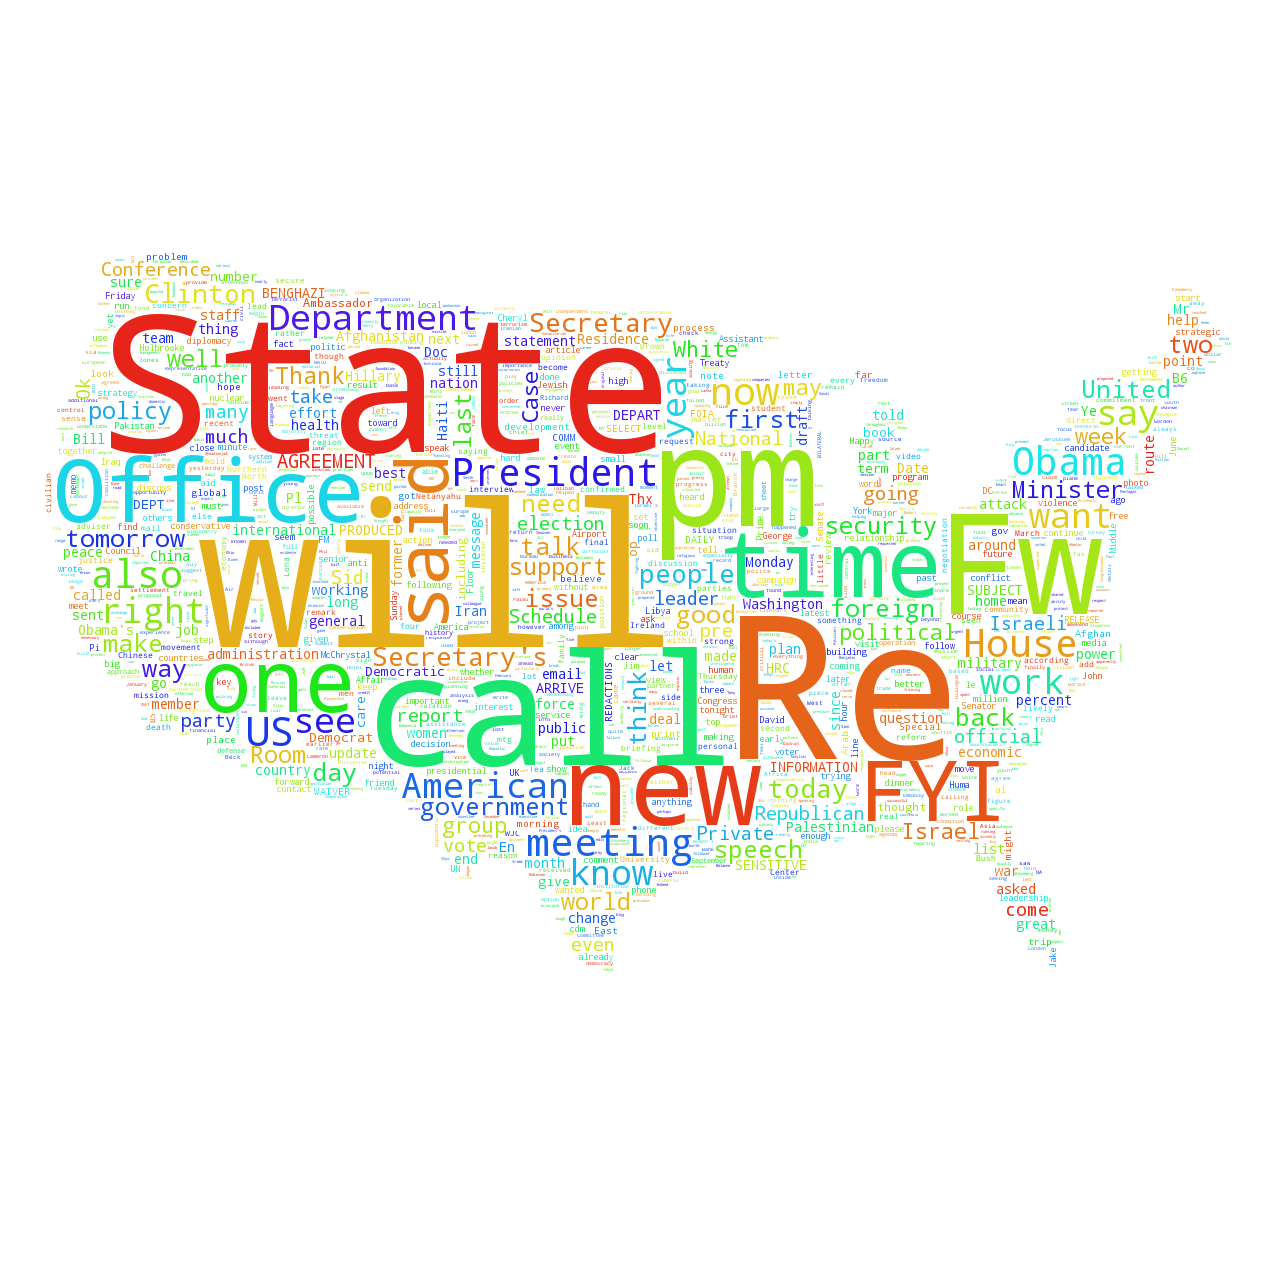

In [7]:
wc = WordCloud(background_color="white", max_words=2000, mask=mask)
wordcloud = wc.generate(rawText)
wordcloud.to_file(path.join(d, "wordcloud_raw.png"))
Image(filename='wordcloud_raw.png')

As expected, the result is not very informative. First, we can see that some of the most frequent words are "Re" and "Fw" taken from every subject field. We can also see that some common verbs as "will" or "said" are quite meaningful aswell. Lets try to achieve a cleaner viz now. 

### 1.2 Word cloud with preprocessing 

The preprocess pipeline will consist three steps: stop word filtering, lemming and stemming. 

To filter the stop words we will check the "nltk" stopword list and also we add custom stopwords for emails. 

In [8]:
def filterStopWords(text):
    try: # Checks if the module nltk is installed  
        tokens = nltk.word_tokenize(text) # Tokenization for better filtering
    except:
        nltk.download() # If it is not installed, downloads it 
        tokens = nltk.word_tokenize(text)
    stopWords = stopwords.words('english') # Retrieves the nltk list of stopwords for english
    customWords = ['re', 'fwd', 'fw', 'pm', 'am', 'also', 'often', 'and', 'every' 'fyi', 'tomorrow', 'today',
                   'well', '.', ',', '"', "'", '?', '&','/', '!', ':', ';', '(', ')',
                   '[', ']', '{', '}', '@', '<', '>', '-', "n't"]
    stopWords += customWords #adds the custom stop words to the nltk stopwords
    filtered = list() 
    for token in tokens:
        token = token.lower() # Only lower letters for better filtering
        if token not in stopWords:
            filtered.append(token) 
    return filtered

# For more info in this process check: http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized

def preprocess(text):
    filtered = filterStopWords(text)
    processed = lemmatize(filtered)
    return ' '.join(processed)

Now we process the rawtext and draw the viz with same parameters as the past word cloud. (Note that we are not doing the stemming yet. We want to compare the results).

In [9]:
procText = preprocess(rawText)

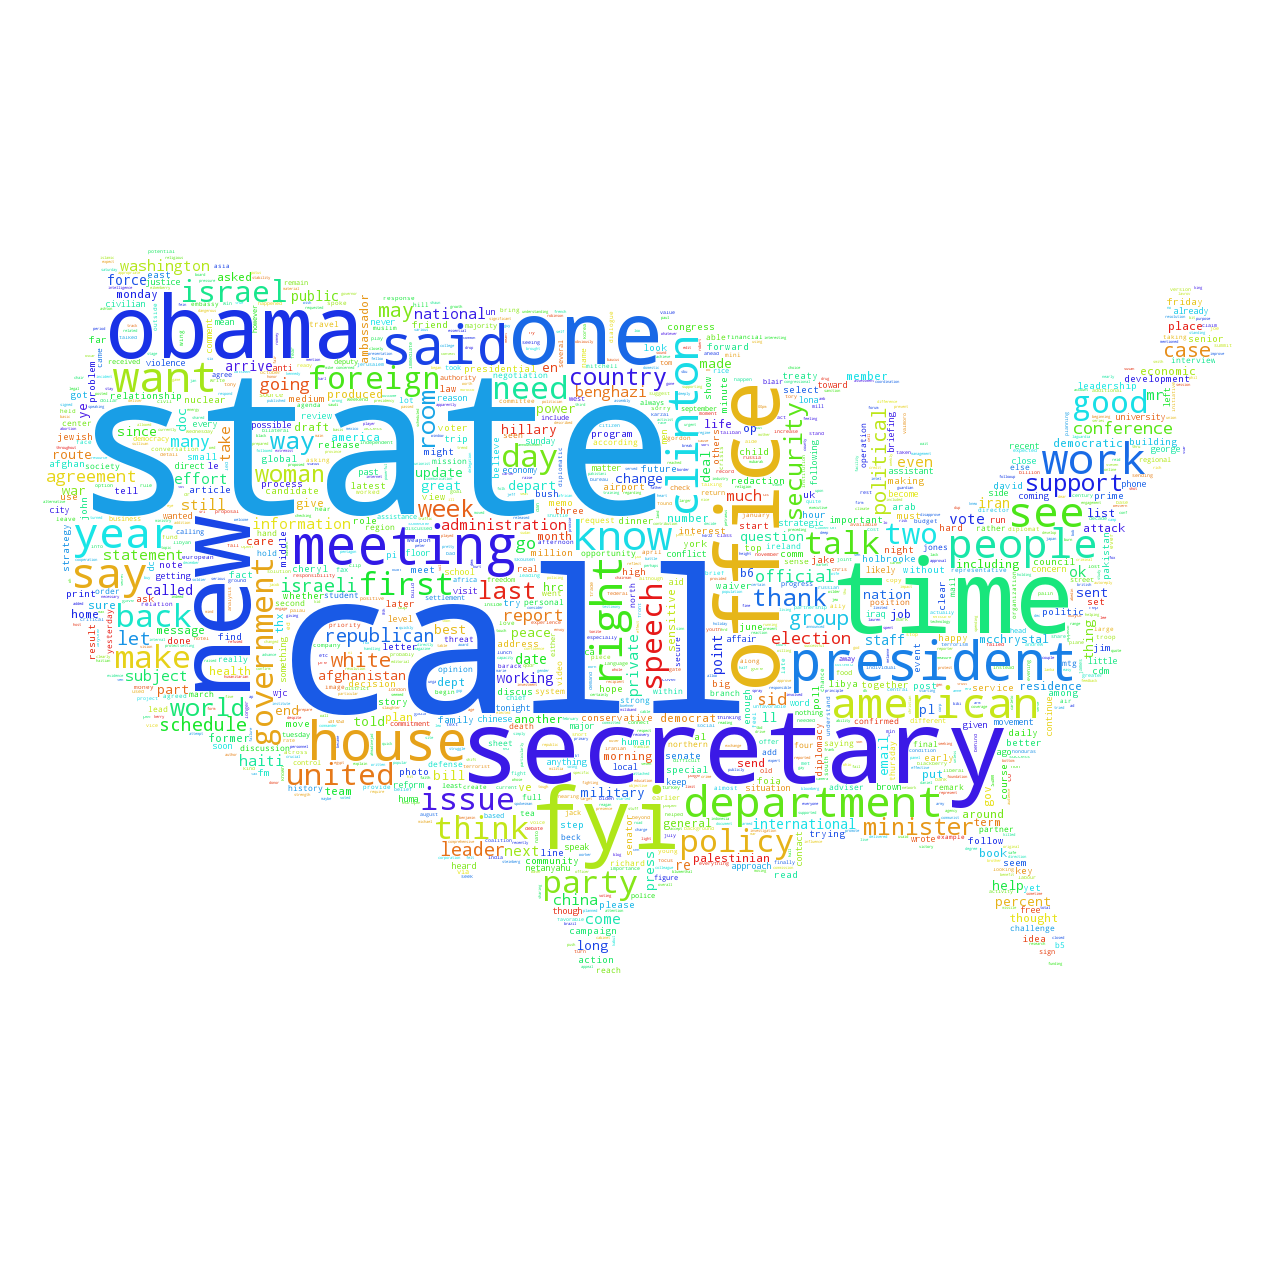

In [10]:
wc = WordCloud(background_color="white", max_words=2000, mask=mask)
wordcloud = wc.generate(procText)
wordcloud.to_file(path.join(d, "wordcloud_proc.png"))
Image(filename='wordcloud_proc.png')

This looks like a very good viz. Very clear and the words are apparently relevant. 

Let's if we can improve further applying the stemming and repeating the viz with the same parameters. 

In [11]:
def lemmAndStem(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)
    stemmed = [stemmer.stem(lema) for lema in lemmatized]
    return stemmed

def preprocess2(text):
    filtered = filterStopWords(text)
    processed = lemmAndStem(filtered)
    return ' '.join(processed)

In [12]:
procText = preprocess2(rawText)

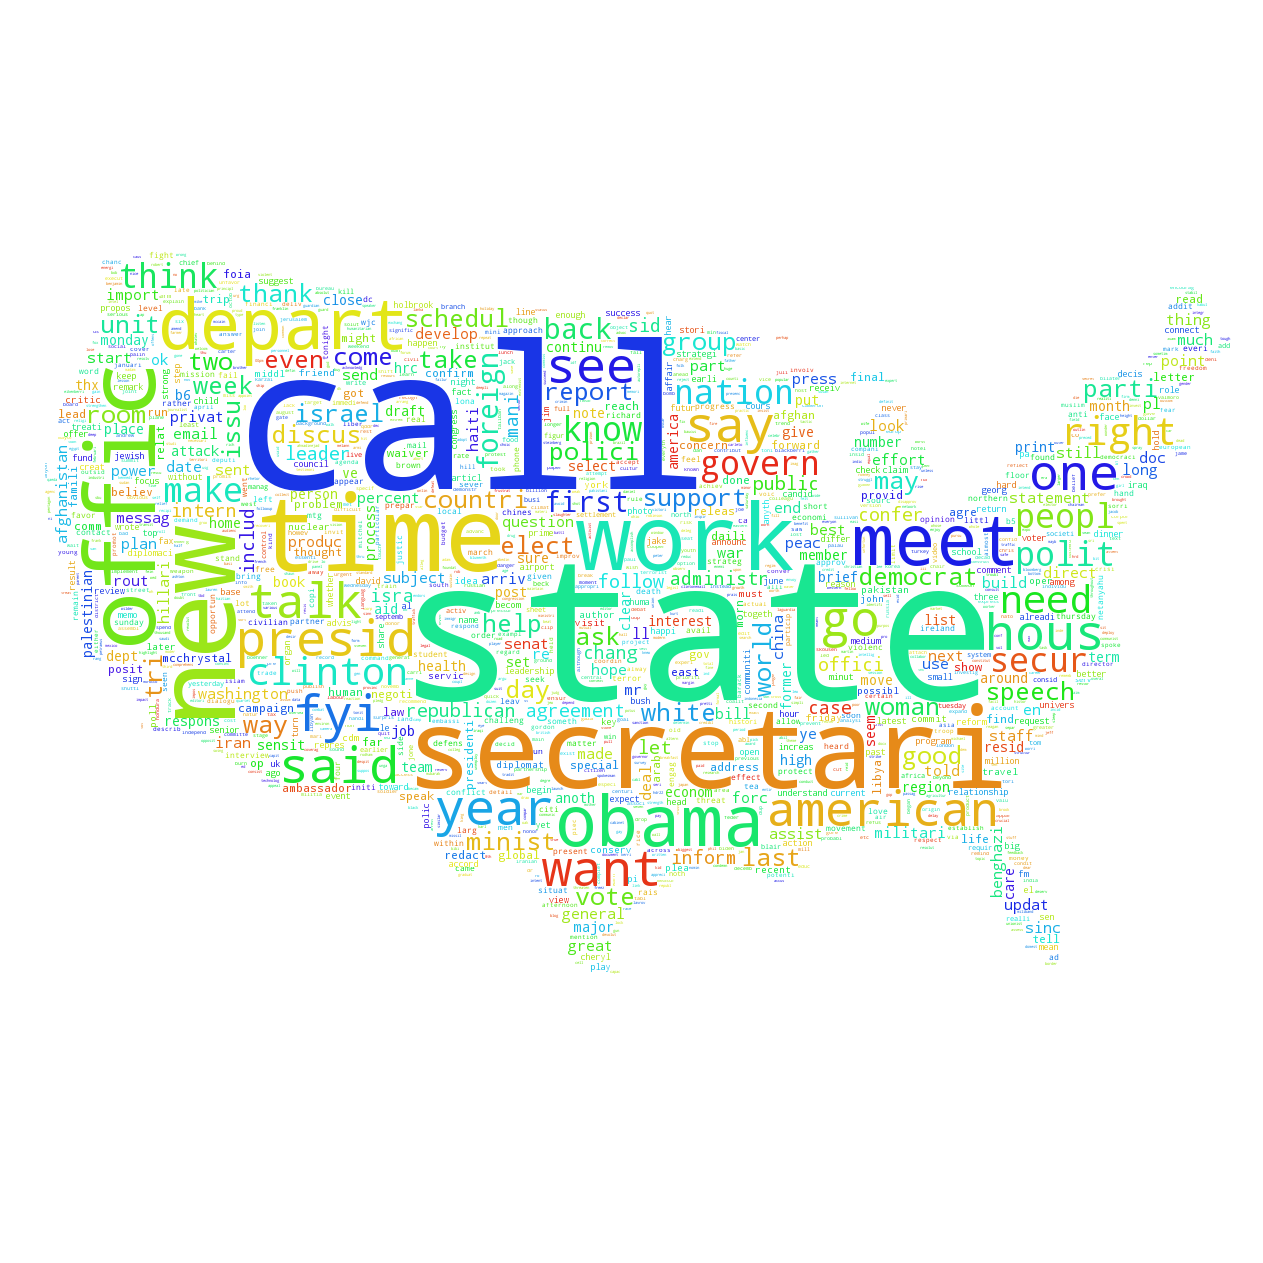

In [13]:
wc = WordCloud(background_color="white", max_words=2000, mask=mask)
wordcloud = wc.generate(procText)
wordcloud.to_file(path.join(d, "wordcloud_proc2.png"))
Image(filename='wordcloud_proc2.png')

This viz is worse than the past. This is because the stemming is reducing all the words to its stem. Converting words like secretary to secretari or office to offic. 

## 2. Sentiment Analysis by country

Is this assignment we will compute the cummulative sentiment analysis using the ntlk utility associated to each country. We will retrieve each country using the pycountry library. 

First we need to loop over each email filter all the data that could distord our result, such as temporal data (days of the week, months, hours) or numbers. 

In [14]:
import re
def clean_days_month(text):
    # Temporal data filtering
    week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'September',
                 'November', 'December']
    hours = ['AM', 'PM']    
    return [word for word in text if word not in (week_days + months + hours)]

def is_number(s):
    # Number filtering
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def word_contains_number(word):
    # Further number filtering 
    return any(ch.isdigit() for ch in word)    
        
def clean_numbers(text):
    return [word for word in text if not is_number(word) and not word_contains_number(word) ]

def clean_symbol(text):
    #Symbol filtering 
    tmp = [re.sub(r'[\w\.-]+@[\w\.-]+', '', word)for word in text]
    return [re.sub('[!@#$,:<>\().]', '', word) for word in tmp]

def clean_text(text):
    #stop words filtering
    tmp = clean_symbol(text.split())
    tmp = filterStopWords(' '.join(clean_days_month(tmp)))
    return ' '.join(clean_numbers(tmp))


Now we use pycountry to import all the countries. Note that in the pycountry library all the countries come in a "name - Extension" format. 

In [15]:
import pycountry
list_countries = list(pycountry.countries)
accumulator = {}
list_token = clean_text(rawText).split()
for country in list_countries:
    suma =  list_token.count(country.name.lower()) + list_token.count(country.alpha_2.lower()) + list_token.count(country.alpha_3.lower().lower())
    accumulator[country.name] = suma

We check the number of times a country appears in the emails, just to check what are the most relevant countries:

In [16]:
proba = pd.Series(accumulator, dtype='str')
proba

Afghanistan                              271
Albania                                   67
Algeria                                    3
American Samoa                             0
Andorra                                   12
Angola                                   135
Anguilla                                   2
Antarctica                                14
Antigua and Barbuda                        2
Argentina                                 21
Armenia                                    9
Aruba                                      1
Australia                                 18
Austria                                    2
Azerbaijan                                14
Bahamas                                    1
Bahrain                                    4
Bangladesh                                10
Barbados                                  11
Belarus                                    0
Belgium                                    4
Belize                                     0
Benin     

Now, we will proceed to do the sentiment analysis using the ntlk utility. Note that we will perform a tokenization and the filtering as we did to create the word cloud. 

In [17]:
from nltk.sentiment.util import *
to_token = nltk.tokenize.RegexpTokenizer(r'\w+|\$')
# Cleaning Body of emails
tmp = []
for i in data.ExtractedBodyText.values:
    tmp.append(clean_text(i) )
data['token_Body'] = tmp
data['token_Body'] = data['token_Body'].apply(to_token.tokenize)
# Cleaning Subject of emails
tmp = []
for i in data.ExtractedSubject.values:
    tmp.append(clean_text(i) )
data['token_Subject'] = tmp
data['token_Subject'] = data['token_Subject'].apply(to_token.tokenize)

/Users/juanluismoralperez/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [18]:
def flatten(list1):
    # Joins two element list in a matrix (just for better computing)
    return [list1[x][y] for x in range(len(list1)) for y in range(len(list1[x]))]

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pycountry

def country_sentiment_row(data_df, df_sentiment_country):
    # Stores the sentiment by country in a row of the dataframe 
    token_data_df_ = data_df[['token_Body','token_Subject']]
    token_list_ = flatten(token_data_df_)
    list_countries = list(pycountry.countries)
    accumulator = {}
    list_token = flatten(token_data_df_)
    # Computes the sentiment for each country
    for country in list_countries:
        suma =  list_token.count(country.name.lower()) + list_token.count(country.alpha_2.lower()) 
        accumulator[country.name] = suma
    sentiment_words = (SentimentIntensityAnalyzer().polarity_scores(data_df.ExtractedBodyText)['compound'])
    # Computes the cummulative sentiment and the frequency
    for contry in accumulator.keys():
        if accumulator[contry] > 0:
            df_sentiment_country.loc[contry]['Times'] = df_sentiment_country.loc[contry]['Times'] + accumulator[contry]
            df_sentiment_country.loc[contry]['Sentiment'] = df_sentiment_country.loc[contry]['Sentiment'] + sentiment_words
            

We create a new dataframe to store the frequency and the cummulative sentiment.

In [20]:
df_countries = pd.DataFrame(columns=['Times','Sentiment'])
for contry in list(pycountry.countries):
    df_countries.set_value(contry.name,['Times','Sentiment'],[0, 0])
df_countries.head()

,Times,Sentiment
Aruba,0.0,0.0
Afghanistan,0.0,0.0
Angola,0.0,0.0
Anguilla,0.0,0.0
Åland Islands,0.0,0.0


In [21]:
_ = data.apply(country_sentiment_row, args=(df_countries,),axis=1)

In [22]:
df_countries.sort_values(by='Times',ascending=False)

,Times,Sentiment
United States,1443.0,194.7009
Israel,435.0,27.5137
Afghanistan,291.0,35.7556
Haiti,288.0,40.0558
China,287.0,33.0619
Réunion,263.0,83.3382
Mauritania,259.0,17.6954
"Venezuela, Bolivarian Republic of",225.0,63.6453
Libya,179.0,4.7448
Pakistan,162.0,24.0730


Now we proceed to plot bar chart with a gradient indicating the sentiment results.

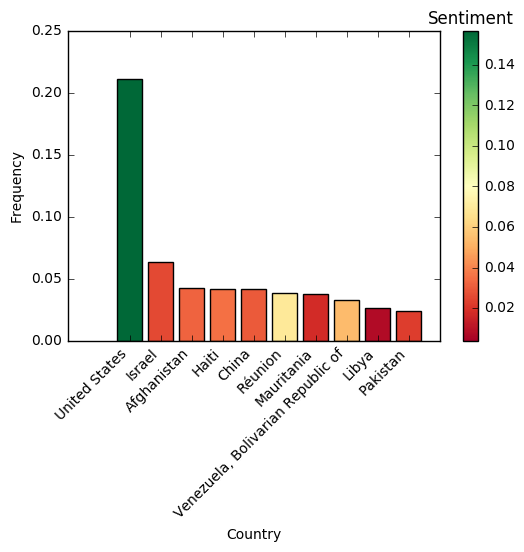

In [23]:
from matplotlib import cm
df_countries['Frequency'] = df_countries['Times']/sum(df_countries['Times'].values)
df_countries['FrequencySentiment'] = df_countries['Sentiment']/sum(df_countries['Sentiment'].values)

# Set up colors : red to green
df_set = df_countries.sort_values(by='Frequency',ascending=False)[:10]
y = np.array(df_set['FrequencySentiment'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(range(df_set.shape[0]), df_set['Frequency'], align='center', tick_label=df_set.index, color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.show()

### 3. Topic modelling

In this assignment, we will perform a topic modeling in order to classify the relevant content. For achieving this we will use the Gensim library and its utilities.

In [35]:
from gensim import models, corpora
import gensim

We perform the same preprocesing pipeline as in the word cloud. 

In [32]:
list_token = clean_text(rawText).split()

We create a dictionary for all the filtered tokens and conver it in a corpus format the gensim library understands. 

In [37]:
dic = corpora.Dictionary([list_token])
corpus = [dic.doc2bow([text]) for text in list_token]

We check the dimensions of this corpus:

In [38]:
print(np.shape(corpus))
print(corpus[0][0])

(240277, 1, 2)
(6970, 1)


Due to the large number of possible topics we will vary the number of topics to classify and store e

In [39]:
for x in range(5,41,5):
    number_of_topics = str(x)
    stem = 'topics'+ number_of_topics+".lda"
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=number_of_topics, id2word=dic)
    lda.save(stem)

In [40]:
number_of_topics = 30
number_of_topics_string = str(number_of_topics)
stem = 'topics' + number_of_topics_string + ".lda"
lda = gensim.models.LdaModel.load(stem)

#prints the number of topics that was inputed when the model was created
np.shape(lda.print_topics(num_topics = number_of_topics))
lda.show_topics(num_topics = number_of_topics)

[(0,
  '0.112*"--" + 0.039*"since" + 0.036*"\'d" + 0.024*"effort" + 0.023*"yes" + 0.019*"worth" + 0.017*"order" + 0.017*"ca" + 0.017*"bring" + 0.016*"night"'),
 (1,
  '0.057*"united" + 0.052*"—" + 0.047*"foreign" + 0.047*"going" + 0.040*"public" + 0.029*"part" + 0.021*"plans" + 0.019*"sorry" + 0.018*"deal" + 0.018*"thought"'),
 (2,
  '0.105*"call" + 0.035*"washington" + 0.028*"beck" + 0.018*"democrats" + 0.017*"mtg" + 0.016*"wars" + 0.015*"general" + 0.014*"instead" + 0.014*"fox" + 0.012*"reagan"'),
 (3,
  '0.064*"said" + 0.056*"department" + 0.034*"support" + 0.031*"saw" + 0.030*"take" + 0.030*"white" + 0.027*"may" + 0.026*"israel" + 0.024*"military" + 0.023*"women"'),
 (4,
  '0.143*"new" + 0.048*"people" + 0.048*"bill" + 0.046*"world" + 0.046*"back" + 0.041*"government" + 0.037*"holbrooke" + 0.023*"come" + 0.017*"ahead" + 0.015*"use"'),
 (5,
  '0.058*"many" + 0.051*"national" + 0.021*"course" + 0.020*"richards" + 0.019*"forces" + 0.016*"ops" + 0.016*"whether" + 0.015*"release" + 0.01

## Bonus Connection 

In [41]:
dataset = data.copy()
dataset.dropna(subset=['MetadataFrom'], inplace=True)
dataset.dropna(subset=['MetadataTo'], inplace=True)

The most relevant features to build the connection between mail are MetadataFrom and MetadataTo. With this two features we can create and networking plot.

In [42]:
dataset_ = dataset[['MetadataFrom', 'MetadataTo']]

We create a set of all contacts; this set will be the edges in our graph. The list between the features From and To is the edges between the node 'From' to the node 'To'. 

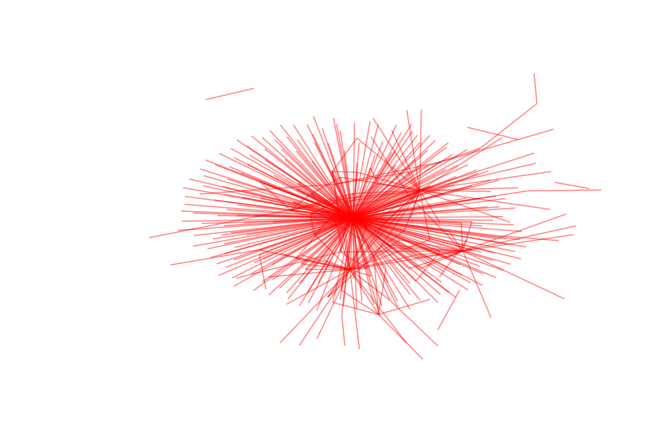

In [43]:
import networkx as nx
G=nx.Graph()
a = set(dataset_.MetadataFrom.values)
b = set(dataset_.MetadataTo.values)
c = set(list(a) + list(b))
G.add_nodes_from(list(c))
edges = [ (x, y) for x, y in dataset_.values.tolist()]
G.add_edges_from(edges)

try: # draw
    pos=nx.spring_layout(G,iterations=10)
    nx.draw(G,pos,node_size=0,alpha=0.4,edge_color='r',font_size=16)
    plt.figure(figsize=(20,20))    
    plt.show()
except: # matplotlib not available
    pass

In this plot we can see some important points. The big one is mail From and To 'H' and the other ones could be mails between the other contacts.

### Problem to improve
In the data you can see some mistakes in the names and emails. 

The diagram flow could be:
1. Recollect all the names
2. Make a set of this names
3. Build a loop to watch all names and see Leveinstein or Hamming distances between the names
4. Correct the wrong names with the high Leveinstein distance or lowest Hamming distance.
5. Make again the plot

With this diagram the last email plot could be changed.